# Time Series Forecasting of Traffic Patterns

This dataset includes traffic of four junctions of a city. The objective is to predict the traffic over the next 4 months.

The sensors on each of these junctions were collecting data at different times, hence you there are traffic data from different time periods. To add to the complexity, some of the junctions have provided limited or sparse data.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
sns.set(style="whitegrid")

## Exploratory Data Analysis

In [2]:
train_df = pd.read_csv(r"data/train_ML_IOT.csv")
train_df["DateTime"] = pd.to_datetime(train_df["DateTime"])
train_df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


Each juntion is converted into a column using a pivot table. Any NaN is converted to a 0.

In [3]:
train_pivot = train_df.pivot(index="DateTime", columns="Junction", values="Vehicles")
train_pivot = train_pivot.fillna(0)
train_pivot

Junction,1,2,3,4
DateTime,,,,
2015-11-01 00:00:00,15.0,6.0,9.0,0.0
2015-11-01 01:00:00,13.0,6.0,7.0,0.0
2015-11-01 02:00:00,10.0,5.0,5.0,0.0
2015-11-01 03:00:00,7.0,6.0,1.0,0.0
2015-11-01 04:00:00,9.0,7.0,2.0,0.0
...,...,...,...,...
2017-06-30 19:00:00,105.0,34.0,33.0,11.0
2017-06-30 20:00:00,96.0,35.0,31.0,30.0
2017-06-30 21:00:00,90.0,31.0,28.0,16.0


The formatted data set is visualized to track the trend of the traffic over time.

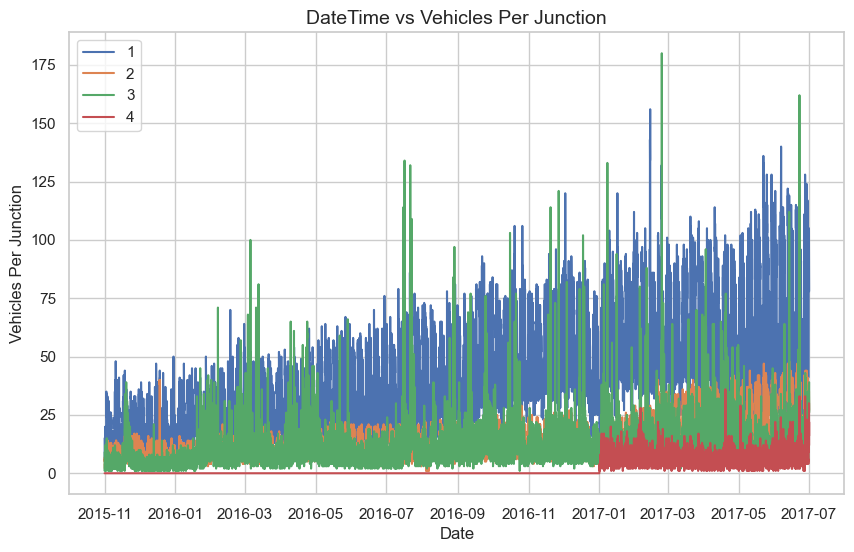

In [4]:
plt.figure(figsize=(10,6))

for column in train_pivot.columns:
    sns.lineplot(data=train_pivot[column], label=column)

plt.title("DateTime vs Vehicles Per Junction", fontsize=14)
plt.ylabel("Vehicles Per Junction", fontsize=12)
plt.xlabel("Date", fontsize=12)

plt.legend()
plt.show()

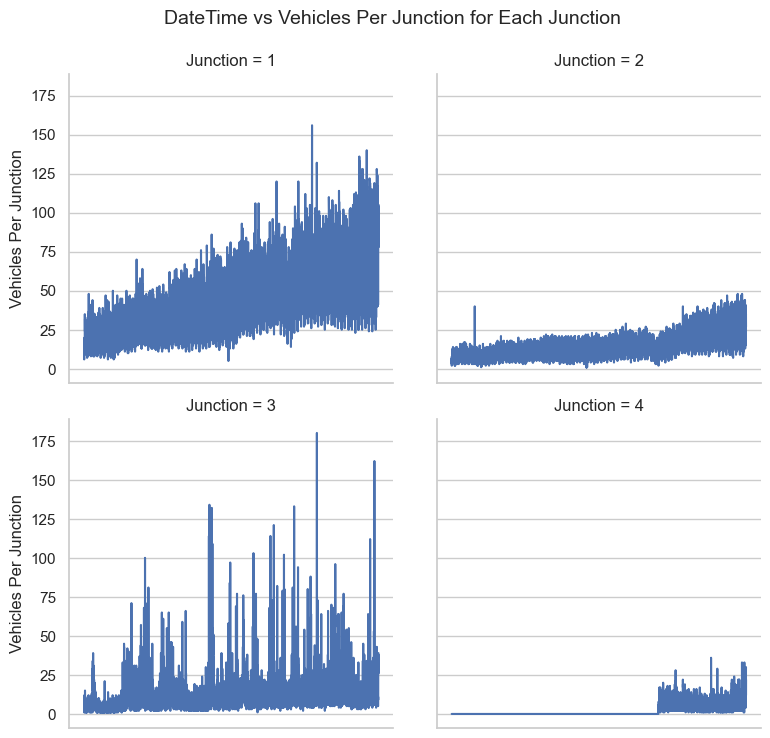

In [5]:
train_melted = train_pivot.reset_index().melt(id_vars='DateTime', var_name='Junction', value_name='Vehicles Per Junction')
train_melted = train_melted[train_melted["Junction"].isin((1, 2, 3, 4))]

g = sns.FacetGrid(train_melted, col='Junction', col_wrap=2, height=4)
g.map(sns.lineplot, 'DateTime', 'Vehicles Per Junction')
g.set(xticks=[], xlabel='')
g.fig.suptitle('DateTime vs Vehicles Per Junction for Each Junction', fontsize=14)
g.fig.subplots_adjust(top=0.9)

plt.show()
